In [1]:
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
%matplotlib inline
from sklearn.feature_selection import RFECV
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from io import StringIO
from zipfile import ZipFile
from urllib.request import urlopen
from io import BytesIO
import matplotlib.pyplot as plt
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
from multiprocessing import Process, Lock,Manager
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn import metrics

# Load the online news dataset

In [2]:
url = urlopen("https://s3.amazonaws.com/assignment3datasets/OnlineNewsPopularity.zip")
f = ZipFile(BytesIO(url.read()))
for item in f.namelist():
    print("File in zip: "+  item)
# find the first matching csv file in the zip:
match = [s for s in f.namelist() if ".csv" in s][0]

df = pd.read_csv(f.open(match), low_memory=False)

File in zip: OnlineNewsPopularity/
File in zip: OnlineNewsPopularity/OnlineNewsPopularity.names
File in zip: OnlineNewsPopularity/OnlineNewsPopularity.csv


In [3]:
df.columns = df.columns.str.strip()
df

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.700000,-0.350000,-0.600000,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.700000,-0.118750,-0.125000,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.000000,-0.466667,-0.800000,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.800000,-0.369697,-0.600000,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.000000,-0.220192,-0.500000,-0.050000,0.454545,0.136364,0.045455,0.136364,505
5,http://mashable.com/2013/01/07/beewi-smart-toys/,731.0,10.0,370.0,0.559889,1.0,0.698198,2.0,2.0,0.0,...,0.136364,0.600000,-0.195000,-0.400000,-0.100000,0.642857,0.214286,0.142857,0.214286,855
6,http://mashable.com/2013/01/07/bodymedia-armba...,731.0,8.0,960.0,0.418163,1.0,0.549834,21.0,20.0,20.0,...,0.100000,1.000000,-0.224479,-0.500000,-0.050000,0.000000,0.000000,0.500000,0.000000,556
7,http://mashable.com/2013/01/07/canon-poweshot-n/,731.0,12.0,989.0,0.433574,1.0,0.572108,20.0,20.0,20.0,...,0.100000,1.000000,-0.242778,-0.500000,-0.050000,1.000000,0.500000,0.500000,0.500000,891
8,http://mashable.com/2013/01/07/car-of-the-futu...,731.0,11.0,97.0,0.670103,1.0,0.836735,2.0,0.0,0.0,...,0.400000,0.800000,-0.125000,-0.125000,-0.125000,0.125000,0.000000,0.375000,0.000000,3600
9,http://mashable.com/2013/01/07/chuck-hagel-web...,731.0,10.0,231.0,0.636364,1.0,0.797101,4.0,1.0,1.0,...,0.100000,0.500000,-0.238095,-0.500000,-0.100000,0.000000,0.000000,0.500000,0.000000,710


# Categorize the shares

In [4]:
# handle goal attrubte to binary
popular = df.shares >= 1400
unpopular = df.shares < 1400

df.loc[popular,'shares'] = 1
df.loc[unpopular,'shares'] = 0

# Eliminating Highly correlated columns and irrelevant columns

In [5]:
# Get the features from dataset
df = df.drop("url",axis=1)
df = df.drop("timedelta",axis= 1)
df = df.drop("kw_avg_min",axis= 1)
df = df.drop("n_non_stop_unique_tokens",axis= 1)
df = df.drop("n_non_stop_words",axis= 1)

# Test Train Split

In [6]:
X = df.drop(["shares"],axis=1)
y = df['shares']

In [7]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

C:\Users\lalwa\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)



# Confusion Matrix
A confusion matrix is a technique for summarizing the performance of a classification algorithm.

Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset.

Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making.
### The confusion matrix shows the ways in which your classification model is confused when it makes predictions.

True Positives (TP) - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes.

True Negatives (TN) - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no

False Positives (FP) – When actual class is no and predicted class is yes

False Negatives (FN) – When actual class is yes but predicted class in no

Accuracy - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. 

Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. 

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. 

F1 score - F1 Score is the weighted average of Precision and Recall.

F1 Score = 2*(Recall * Precision) / (Recall + Precision)



# Logistic Regression

In [8]:
def logred(X_train, y_train,X_test,y_test,return_dict_logred):

    logreg = LogisticRegression(solver = 'lbfgs')
    logreg.fit(X_train, y_train)

    y_train_predicted = logreg.predict(X_train)
    y_test_predicted = logreg.predict(X_test)

    #print(metrics.classification_report(y_train, y_train_predicted))
     
    conf_mat_logred = metrics.confusion_matrix(y_test, y_test_predicted)
    print(pd.crosstab(y_test, y_test_predicted, rownames=['Actual'], colnames=['Predicted'], margins=True))

    # Compute ROC curve and AUC (Area under the Curve)
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)
    
    roc_auc_logred = metrics.auc(false_positive_rate, true_positive_rate)
    return_dict_logred['roc_auc_logred']=roc_auc_logred
    return_dict_logred['conf_mat_logred']=conf_mat_logred
    
    
    ## Plot ROC Curve
    plt.title("Logistic Regression")
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc_logred)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


# Random Forest

In [9]:
def rf(X_train, y_train,X_test,y_test,return_dict_rf):
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_train)

    y_train_predicted = rf.predict(X_train)
    y_test_predicted = rf.predict(X_test)
    
    
    conf_mat_rf = metrics.confusion_matrix(y_test, y_test_predicted)
    print(pd.crosstab(y_test, y_test_predicted, rownames=['Actual'], colnames=['Predicted'], margins=True))

    # Compute ROC curve and AUC (Area under the Curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)
    
    roc_auc_rf = metrics.auc(false_positive_rate, true_positive_rate)
    return_dict_rf['roc_auc_rf']=roc_auc_rf
    return_dict_rf['conf_mat_rf']=conf_mat_rf
    
    ## Plot ROC Curve
    plt.title("Random Forest")
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc_rf)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


# SVC

In [10]:
def svm():
    from sklearn.svm import SVC

    clf = SVC()
    clf.fit(X_train, y_train)

    #y_train_predicted = clf.predict(X_train)
    y_test_predicted = clf.predict(X_test)
    
    global conf_mat_svm
    conf_mat_svm=metrics.confusion_matrix(y_test, y_test_predicted)
    print(pd.crosstab(y_test, y_test_predicted, rownames=['Actual'], colnames=['Predicted'], margins=True))

    # Compute ROC curve and AUC (Area under the Curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_test_predicted)
    global roc_auc_svm
    roc_auc_svm = metrics.auc(false_positive_rate, true_positive_rate)

    ## Plot ROC Curve
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc_svm)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [11]:
manager=Manager()
return_dict_logred=manager.dict()
return_dict_rf=manager.dict()
return_dict_nn=manager.dict()

Predicted     0     1    All
Actual                      
0          2791  2794   5585
1          1956  4353   6309
All        4747  7147  11894


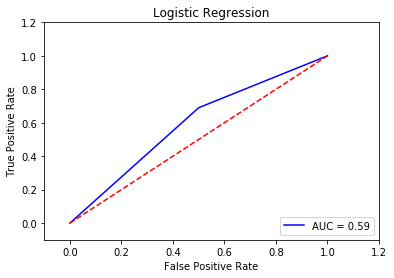

Predicted     0     1    All
Actual                      
0          3356  2229   5585
1          1795  4514   6309
All        5151  6743  11894


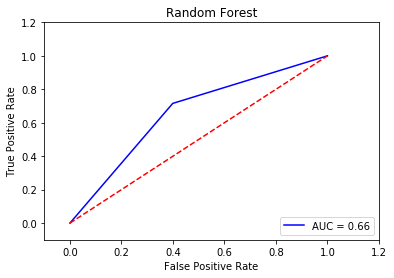

Predicted  0      1    All
Actual                    
0          4   5581   5585
1          1   6308   6309
All        5  11889  11894


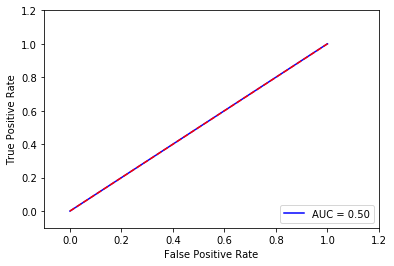

In [12]:
logred(X_train, y_train,X_test,y_test,return_dict_logred)
rf(X_train, y_train,X_test,y_test,return_dict_rf)
svm()